* set random seed
* pre-trained models eg. Inception, EfficientNet


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from tensorflow import keras

## Data loading

In [12]:
cinic_directory_train = './archive/train/'
cinic_directory_test = './archive/test/'
cinic_directory_valid = './archive/valid/'

class_name = []
file_name='output_fromKeras.csv'
optimiser='adamax' # les best : Adam, nadam et adamax
nb_epochs=30
batch_size_choice=16
image_size=(32, 32)
learning_rate = [0.1, 0.01, 0.001]
loss_func='sparse_categorical_crossentropy'

In [13]:
def load_data(path, label_mode = 'categorical', batch_size = 16, image_size = (32,32)):
    return keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode=label_mode,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=1111
    
)

In [15]:
# loading in the data 
train_ds = load_data(cinic_directory_train, label_mode='categorical',
                      batch_size=batch_size_choice,image_size=image_size)
test_ds = load_data(cinic_directory_test, label_mode='categorical',
                      batch_size=batch_size_choice,image_size=image_size)
valid_ds = load_data(cinic_directory_valid, label_mode='categorical',
                      batch_size=batch_size_choice,image_size=image_size)

Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.


In [16]:
class_names= train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
tf.autograph.set_verbosity(
    level=0, alsologtostdout=False
)

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    keras.layers.Resizing(224, 224),
    keras.layers.Rescaling(1./255),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    keras.layers.GaussianNoise(0.1),

])

In [11]:
from tensorflow.random import gamma as tf_random_gamma

In [12]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = keras.ops.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = keras.ops.reshape(l, (batch_size, 1, 1, 1))
    y_l = keras.ops.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = (images_one * x_l + images_two * (1 - x_l))
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [16]:

train_zipped = tf.data.Dataset.zip((train_ds, train_ds.shuffle(111)))
train_ds_mu = train_zipped.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [24]:

# valid_zipped = tf.data.Dataset.zip((valid_ds, valid_ds.shuffle(111)))
# valid_ds_mu = valid_zipped.map(
#     lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[0.         0.57706314 0.         0.         0.         0.
 0.42293686 0.         0.         0.        ], shape=(10,), dtype=float32)
tf.Tensor(
[0.         0.09475648 0.         0.         0.9052435  0.
 0.         0.         0.         0.        ], shape=(10,), dtype=float32)
tf.Tensor(
[0.         0.00110332 0.         0.         0.99889666 0.
 0.         0.         0.         0.        ], shape=(10,), dtype=float32)
tf.Tensor(
[0.         0.         0.         0.00400066 0.         0.
 0.         0.99599934 0.         0.        ], shape=(10,), dtype=float32)
tf.Tensor(
[0.         0.         0.         0.79859155 0.         0.
 0.         0.         0.         0.20140845], shape=(10,), dtype=float32)
tf.Tensor(
[0.         0.         0.         0.36793298 0.         0.
 0.         0.         0.         0.632067  ], shape=(10,), dtype=float32)
tf.Tensor(
[0.         0.         0.00157044 0.         0.         0.
 0.         0.         0.99842954 0.        ], shape=(10,), 

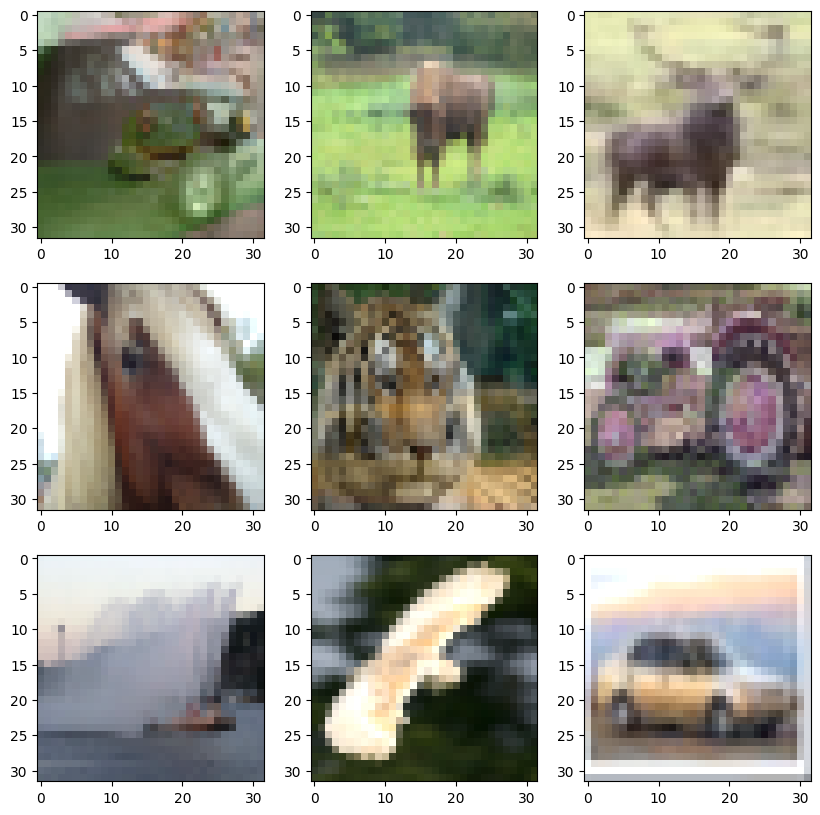

In [18]:

sample_images, sample_labels = next(iter(train_ds_mu))

# Let's preview 9 samples from the dataset
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(sample_images[i])
    plt.imshow(sample_images[i].numpy().squeeze()/225.)
    print(sample_labels[i])
    # print(sample_images[i])

    # plt.axis("off")

## Custom Model

In [19]:
import keras_cv

/Users/zuzannaglinka/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Without any augmentation

In [20]:
def custom_model(input_shape, n_classes):
    model = keras.Sequential(
        [

            keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPooling2D((2, 2)),

            keras.layers.Flatten(),
            keras.layers.Dropout(0.2),

            # Hidden layer
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dropout(0.2),

            # last hidden layer i.e.. output layer
            keras.layers.Dense(n_classes, activation='softmax')
        ]
    )
    return model

In [18]:
model = custom_model(input_shape = (32,32,3), n_classes=10)
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=3))#, learning_rate =learning_rate])
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 247s 43ms/step - accuracy: 0.3698 - loss: 1.7970 - val_accuracy: 0.5326 - val_loss: 1.2816
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 244s 43ms/step - accuracy: 0.5326 - loss: 1.3001 - val_accuracy: 0.5714 - val_loss: 1.1806
Epoch 3/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 244s 43ms/step - accuracy: 0.5942 - loss: 1.1382 - val_accuracy: 0.6078 - val_loss: 1.0865
Epoch 4/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 253s 45ms/step - accuracy: 0.6328 - loss: 1.0334 - val_accuracy: 0.6492 - val_loss: 0.9890
Epoch 5/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 251s 45ms/step - accuracy: 0.6623 - loss: 0.9477 - val_accuracy: 0.6534 - val_loss: 0.9891
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.6516 - loss: 0.9962
Test accuracy: 65.16%


In [28]:
for learning_rate in [0.05, 0.01, 0.001]:
    print('Learinig rate: '+str(learning_rate))
    model = custom_model(input_shape = (32,32,3), n_classes=10)
    model.load_weights("initial_weights.weights.h5")
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])
    _, test_acc = model.evaluate(test_ds)
    print("Test accuracy: {:.2f}%".format(test_acc * 100))

Learinig rate: 0.05
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 260s 46ms/step - accuracy: 0.1028 - loss: 5.5435 - val_accuracy: 0.1000 - val_loss: 2.7143
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 253s 45ms/step - accuracy: 0.1017 - loss: 2.3114 - val_accuracy: 0.1000 - val_loss: 2.7227
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.1002 - loss: 2.6083
Test accuracy: 10.00%
Learinig rate: 0.01
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 263s 46ms/step - accuracy: 0.1764 - loss: 2.7627 - val_accuracy: 0.2308 - val_loss: 10.9411
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 259s 46ms/step - accuracy: 0.2612 - loss: 1.9031 - val_accuracy: 0.3734 - val_loss: 1.6792
Epoch 3/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 261s 46ms/step - accuracy: 0.3108 - loss: 1.7819 - val_accuracy: 0.3290 - val_loss: 1.8231
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - accuracy: 0.3270 - loss: 1.6887
Test accuracy: 32.91%
Learinig rate: 0.001
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 268s 47ms/step - accuracy: 0.

In [29]:
print('Learinig rate: 0.0001')
model = custom_model(input_shape = (32,32,3), n_classes=10)
model.load_weights("initial_weights.weights.h5")
optimizer = keras.optimizers.Adam(learning_rate=0.0001
)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Learinig rate: 0.0001
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 309s 54ms/step - accuracy: 0.3208 - loss: 1.9625 - val_accuracy: 0.4908 - val_loss: 1.3835
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 296s 53ms/step - accuracy: 0.4921 - loss: 1.3888 - val_accuracy: 0.5588 - val_loss: 1.2144
Epoch 3/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 271s 48ms/step - accuracy: 0.5553 - loss: 1.2164 - val_accuracy: 0.5941 - val_loss: 1.1235
Epoch 4/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 255s 45ms/step - accuracy: 0.6003 - loss: 1.1039 - val_accuracy: 0.6138 - val_loss: 1.0729
Epoch 5/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 251s 45ms/step - accuracy: 0.6331 - loss: 1.0175 - val_accuracy: 0.6269 - val_loss: 1.0443
Epoch 6/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 279s 50ms/step - accuracy: 0.6607 - loss: 0.9388 - val_accuracy: 0.6352 - val_loss: 1.0232
Epoch 7/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 300s 53ms/step - accuracy: 0.6871 - loss: 0.8712 - val_accuracy: 0.6377 - val_loss: 1.0291
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - 

In [21]:
print('Learinig rate: 0.005')
model = custom_model(input_shape = (32,32,3), n_classes=10)
model.load_weights("initial_weights.weights.h5")
optimizer = keras.optimizers.Adam(learning_rate=0.005
)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Learinig rate: 0.005
Epoch 1/20


5625/5625 ━━━━━━━━━━━━━━━━━━━━ 253s 44ms/step - accuracy: 0.2115 - loss: 2.2914 - val_accuracy: 0.3841 - val_loss: 1.6424
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 251s 45ms/step - accuracy: 0.4181 - loss: 1.5760 - val_accuracy: 0.5019 - val_loss: 1.3807
Epoch 3/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 255s 45ms/step - accuracy: 0.4955 - loss: 1.3916 - val_accuracy: 0.5305 - val_loss: 1.3397
Epoch 4/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 239s 42ms/step - accuracy: 0.5279 - loss: 1.3138 - val_accuracy: 0.4902 - val_loss: 1.8162
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.4875 - loss: 1.8616
Test accuracy: 48.80%


In [23]:
d = {}
for batch_size in [8, 16, 32, 64, 128]:
    train_ds = load_data(cinic_directory_train, label_mode='categorical',
                      batch_size=batch_size,image_size=image_size)
    test_ds = load_data(cinic_directory_test, label_mode='categorical',
                        batch_size=batch_size,image_size=image_size)
    valid_ds = load_data(cinic_directory_valid, label_mode='categorical',
                        batch_size=batch_size,image_size=image_size)
    print('Batch size: '+str(batch_size))
    model = custom_model(input_shape = (32,32,3), n_classes=10)
    model.load_weights("initial_weights.weights.h5")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])
    _, test_acc = model.evaluate(test_ds)
    d[batch_size] = test_acc
    print("Test accuracy: {:.2f}%".format(test_acc * 100))

Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Batch size: 8
Epoch 1/20
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 295s 26ms/step - accuracy: 0.3441 - loss: 1.8633 - val_accuracy: 0.4268 - val_loss: 1.6099
Epoch 2/20
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 291s 26ms/step - accuracy: 0.5216 - loss: 1.3282 - val_accuracy: 0.5813 - val_loss: 1.1601
Epoch 3/20
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 284s 25ms/step - accuracy: 0.5895 - loss: 1.1480 - val_accuracy: 0.6234 - val_loss: 1.0664
Epoch 4/20
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 287s 26ms/step - accuracy: 0.6269 - loss: 1.0405 - val_accuracy: 0.6215 - val_loss: 1.0742
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.6199 - loss: 1.0820
Test accuracy: 62.02%
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Batch size: 16
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 247s 43ms/step - accuracy: 0.

In [24]:
d

{8: 0.6202222108840942,
 16: 0.660111129283905,
 32: 0.5913333296775818,
 64: 0.6119999885559082,
 128: 0.6260555386543274}

In [26]:
accs = {}
for image_size in [(32,32), (256, 256)]:
    train_ds = load_data(cinic_directory_train, label_mode='categorical',
                      batch_size=batch_size_choice,image_size=image_size)
    test_ds = load_data(cinic_directory_test, label_mode='categorical',
                        batch_size=batch_size_choice,image_size=image_size)
    valid_ds = load_data(cinic_directory_valid, label_mode='categorical',
                        batch_size=batch_size_choice,image_size=image_size)
    print('Image size: '+str(image_size))
    model = custom_model(input_shape = (image_size[0],image_size[1],3), n_classes=10)
    model.load_weights("initial_weights.weights.h5")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])
    _, test_acc = model.evaluate(test_ds)
    accs[image_size] = test_acc
    print("Test accuracy: {:.2f}%".format(test_acc * 100))

Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Found 90000 files belonging to 10 classes.
Image size: (32, 32)
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 289s 50ms/step - accuracy: 0.3639 - loss: 1.8079 - val_accuracy: 0.5344 - val_loss: 1.2947
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 285s 51ms/step - accuracy: 0.5292 - loss: 1.3085 - val_accuracy: 0.5710 - val_loss: 1.1876
Epoch 3/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 285s 51ms/step - accuracy: 0.5888 - loss: 1.1483 - val_accuracy: 0.6120 - val_loss: 1.0890
Epoch 4/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 281s 50ms/step - accuracy: 0.6285 - loss: 1.0375 - val_accuracy: 0.6440 - val_loss: 1.0042
Epoch 5/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 267s 47ms/step - accuracy: 0.6602 - loss: 0.9523 - val_accuracy: 0.6632 - val_loss: 0.9629
Epoch 6/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 256s 46ms/step - accuracy: 0.6869 - loss: 0.8745 - val_accuracy: 0.6500 - val_loss: 1.0095
Epoch 7/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 260s 46ms/

KeyboardInterrupt: 